1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture

In [2]:
# Load cleaned dataset 
df = pd.read_csv("air_12318.csv")
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

In [3]:
# Fix unit-scaled columns (if they exist)
if 'freq_Hz*10' in df.columns:
    df['freq_Hz'] = df['freq_Hz*10'] / 10
if 'expwh_Kwh*10' in df.columns:
    df['expwh_Kwh'] = df['expwh_Kwh*10'] / 10
if 'expvar_Kvarh*10' in df.columns:
    df['expvar_Kvarh'] = df['expvar_Kvarh*10'] / 10

In [4]:
df = df.fillna(method='ffill').fillna(method='bfill')

C:\Users\tiaan\AppData\Local\Temp\ipykernel_1360\1282391985.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


2. Feature Engineering

In [5]:
df = df.set_index('time')

In [6]:

# Clip negative power readings and fill NaNs
p = df['ptot_W'].clip(lower=0).fillna(0)

# Log-transform to handle skew
X = np.log1p(p).values.reshape(-1,1)

# Fit Gaussian Mixture with 2 clusters (OFF/ON)
gmm = GaussianMixture(n_components=2, random_state=42).fit(X)
labels = gmm.predict(X)

# Determine which cluster is ON (the one with higher mean power)
means = gmm.means_.flatten()
on_cluster = np.argmax(means)

# Create ON/OFF labels
df['is_running_gmm'] = (labels == on_cluster).astype(int)

# Cross-check with currents (safety net)
df['any_current'] = df[['ia_A','ib_A','ic_A']].sum(axis=1) > 0.1

# Final ON/OFF label
df['is_running'] = ((df['is_running_gmm']==1) | df['any_current']).astype(int)

In [7]:
# Example: calculate current imbalance only when running
df_on = df[df['is_running'] == 1].copy()

df_on['current_imbalance'] = df_on[['ia_A','ib_A','ic_A']].std(axis=1)


In [8]:
# Rolling features (30m window)
df['temp_mean_30m'] = df['temp_Degrees Celsius'].rolling('30min').mean()
df['temp_std_30m']  = df['temp_Degrees Celsius'].rolling('30min').std()

In [9]:

df['fuel_rate'] = df['fuel_%'].diff() / (df.index.to_series().diff().dt.total_seconds()/3600)

In [10]:
# Efficiency
df['efficiency'] = df['ptot_W'] / (df['fuel_rate'].abs() + 1e-5)

In [11]:
# Current balance (if currents exist)
if all(c in df.columns for c in ['ia_A','ib_A','ic_A']):
    df['current_imbalance'] = df[['ia_A','ib_A','ic_A']].std(axis=1)

In [12]:
# Voltage balance (if voltages exist)
if all(c in df.columns for c in ['mVa_V','mVb_V','mVc_V']):
    df['voltage_imbalance'] = df[['mVa_V','mVb_V','mVc_V']].std(axis=1)


In [13]:
# Power factor anomaly flag
if 'pftot_None' in df.columns:
    df['pf_anomaly'] = (df['pftot_None'] < 0.8).astype(int)


In [14]:
# Usage
if 'hours_sec' in df.columns:
    df['hours_cumulative'] = df['hours_sec'] / 3600
    df['hours_rate'] = df['hours_cumulative'].diff()

In [15]:
df = df.reset_index()

3. Anomaly Detection (Isolation Forest)

In [16]:
# Select numeric features only (drop non-features)
feature_cols = [c for c in df.columns if c not in ['time']]
X = df[feature_cols].select_dtypes(include=[np.number]).fillna(0)

In [17]:
# Train Isolation Forest
iso = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
df['anomaly_score'] = iso.fit_predict(X)  # -1 = anomaly, 1 = normal

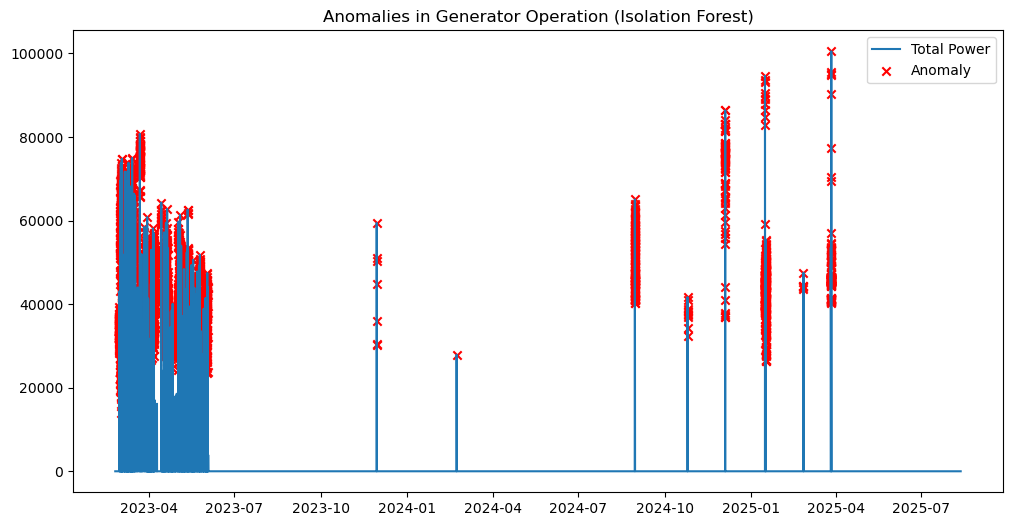

In [18]:
# Plot anomalies over time
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['ptot_W'], label="Total Power")
plt.scatter(df['time'][df['anomaly_score']==-1],
            df['ptot_W'][df['anomaly_score']==-1],
            color='red', marker='x', label="Anomaly")
plt.legend(); plt.title("Anomalies in Generator Operation (Isolation Forest)")
plt.show()

In [19]:
anomalies = df[df['anomaly_score'] == -1]
print(anomalies[['time','temp_Degrees Celsius','pftot_None','fuel_%']].head(20))


                         time  temp_Degrees Celsius  pftot_None  fuel_%
226 2023-02-28 18:02:55+00:00                  56.0        93.0   100.0
227 2023-02-28 18:04:58+00:00                  62.0        92.0   100.0
228 2023-02-28 18:08:59+00:00                  64.0        92.0   100.0
229 2023-02-28 18:10:54+00:00                  57.0        92.0    95.0
230 2023-02-28 18:12:55+00:00                  63.0        92.0   100.0
231 2023-02-28 18:14:54+00:00                  64.0        91.0   100.0
232 2023-02-28 18:16:54+00:00                  59.0        92.0   100.0
233 2023-02-28 18:18:54+00:00                  52.0        92.0   100.0
234 2023-02-28 18:20:54+00:00                  57.0        92.0   100.0
235 2023-02-28 18:22:54+00:00                  59.0        93.0   100.0
236 2023-02-28 18:24:54+00:00                  68.0        93.0   100.0
237 2023-02-28 18:26:53+00:00                  54.0        93.0    95.0
238 2023-02-28 18:28:53+00:00                  56.0        92.0 


Focus only on ON cycles

In [20]:
df_on = df[df['is_running'] == 1].copy()

In [21]:
# Select numeric features only
feature_cols = [c for c in df_on.columns if c not in ['time']]
X = df_on[feature_cols].select_dtypes(include=['number']).fillna(0)

Train Isolation Forest

In [22]:
iso = IsolationForest(
    n_estimators=200,
    contamination=0.005,   # 0.5% anomalies (tune this number)
    random_state=42
)

In [23]:
df_on['anomaly_score'] = iso.fit_predict(X)   # -1 = anomaly, 1 = normal


 Merge results back into main dataframe

In [24]:
df = df.merge(
    df_on[['time','anomaly_score']],
    on='time',
    how='left'
)

In [25]:
# Merge anomaly results from ON cycles back into full dataframe
if 'anomaly_score' in df_on.columns:
    df = df.merge(
        df_on[['time','anomaly_score']],
        on='time',
        how='left'
    )

# If anomaly_score didn’t exist (empty df_on), create it
if 'anomaly_score' not in df.columns:
    df['anomaly_score'] = 1

# Fill OFF-cycle rows (NaN) as normal
df['anomaly_score'] = df['anomaly_score'].fillna(1)


 Plot anomalies vs power

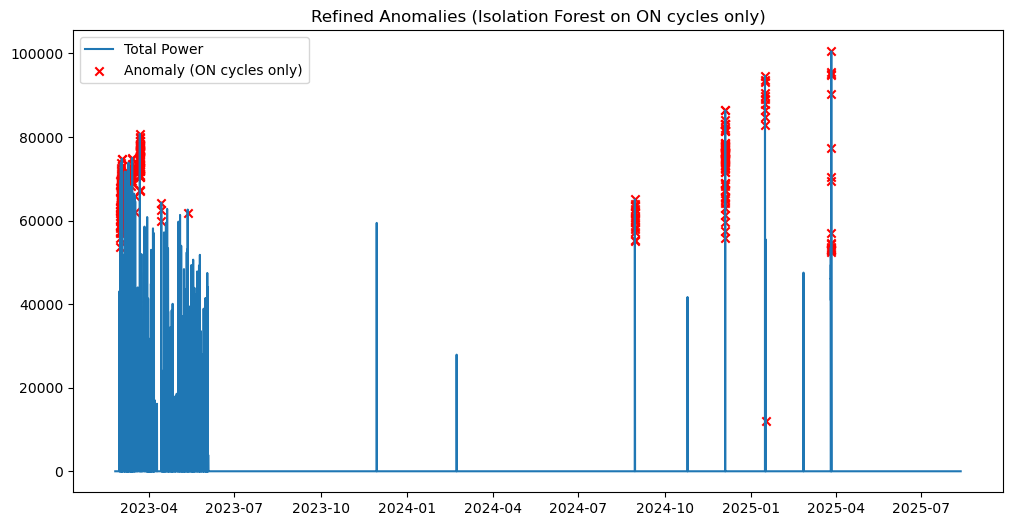

In [26]:
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['ptot_W'], label="Total Power")
plt.scatter(df['time'][df['anomaly_score']==-1],
            df['ptot_W'][df['anomaly_score']==-1],
            color='red', marker='x', label="Anomaly (ON cycles only)")
plt.legend()
plt.title("Refined Anomalies (Isolation Forest on ON cycles only)")
plt.show()

In [27]:
anomalies = df[df['anomaly_score'] == -1]
print(anomalies[['time','temp_Degrees Celsius','pftot_None','fuel_%']].head(20))


                          time  temp_Degrees Celsius  pftot_None  fuel_%
754  2023-03-01 14:21:43+00:00                  53.0        91.0    95.0
755  2023-03-01 14:31:43+00:00                  60.0        92.0    95.0
756  2023-03-01 14:33:43+00:00                  49.0        92.0    95.0
757  2023-03-01 14:35:43+00:00                  54.0        92.0   100.0
758  2023-03-01 14:39:43+00:00                  56.0        91.0   100.0
759  2023-03-01 14:41:43+00:00                  57.0        91.0    95.0
760  2023-03-01 14:43:43+00:00                  56.0        91.0   100.0
761  2023-03-01 14:47:43+00:00                  60.0        92.0   100.0
762  2023-03-01 14:49:43+00:00                  57.0        91.0    95.0
763  2023-03-01 14:53:43+00:00                  65.0        91.0    95.0
764  2023-03-01 14:55:43+00:00                  61.0        92.0   100.0
767  2023-03-01 15:09:43+00:00                  71.0        91.0   100.0
771  2023-03-01 15:17:41+00:00                  60.

4. Save Outputs

In [28]:
# Save full dataset locally in compressed parquet
df.to_parquet("air_12318_features_full.parquet", index=False)

In [29]:
# Save smaller sample for Git (first 50k rows)
df.sample(50000, random_state=42).to_csv("air_12318_features_sample.csv", index=False)

In [30]:
print("✅ Feature engineering + anomaly detection complete.")
print("Full dataset saved as air_12318_features_full.parquet")
print("Sample dataset saved as air_12318_features_sample.csv (safe for Git)")

✅ Feature engineering + anomaly detection complete.
Full dataset saved as air_12318_features_full.parquet
Sample dataset saved as air_12318_features_sample.csv (safe for Git)
